# Visualize river classification system

1. Glaciers
2. Continental
3. Other

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import matplotlib
import pickle
import xarray as xr
import cmocean
from matplotlib import colors
from mpl_toolkits.basemap import Basemap, cm

%matplotlib inline

Parameters:

In [70]:
# domain dimensions:
imin, imax = 160, 800
jmin, jmax = 1100, 2180

# runoff period:
rf_year  = 2015
rf_month = 8    # september 

# colours:
c_continent  = '#ce9169'
c_glacier    = '#36ab92'
c_other      = '#f6f6f6'
outline_color= '#373736'
land_color   = '#d8d8d6'
grid_color   = '#c9c9c9'

Load files:

In [71]:
rf_file = xr.open_dataset(f'/data/brogalla/runoff/ANHA12_runoff_monthly_combined_Dai_Trenberth_Bamber_y{rf_year}.nc')
lon_rf  = rf_file['nav_lon'].values
lat_rf  = rf_file['nav_lat'].values
rf      = rf_file['runoff'].values[rf_month]

mesh  = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb.nc')
mesh_lon     = mesh['nav_lon'].values
mesh_lat     = mesh['nav_lat'].values
mesh_bathy   = mesh['tmask'].values[0,:,:,:]
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)

ncd         = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/river_class-202005.nc')
river_class = ncd['rclass'].values

# Place NaNs where there is no runoff
rf = np.ma.masked_where((rf==0), rf)
rf = np.ma.masked_where((mesh_bathy[0,:,:]< 0.1), rf)
lon_rf = np.ma.masked_where(rf.mask, lon_rf)
lat_rf = np.ma.masked_where(rf.mask, lat_rf)
river_class = np.ma.masked_where(rf.mask, river_class)

# Mask land masked areas for mesh grid:
grid_lon = np.ma.masked_where((mesh_bathy[0,:,:] < 0.1), mesh_lon)
grid_lat = np.ma.masked_where(grid_lon.mask, mesh_lat)

##### Map with bathymetry background

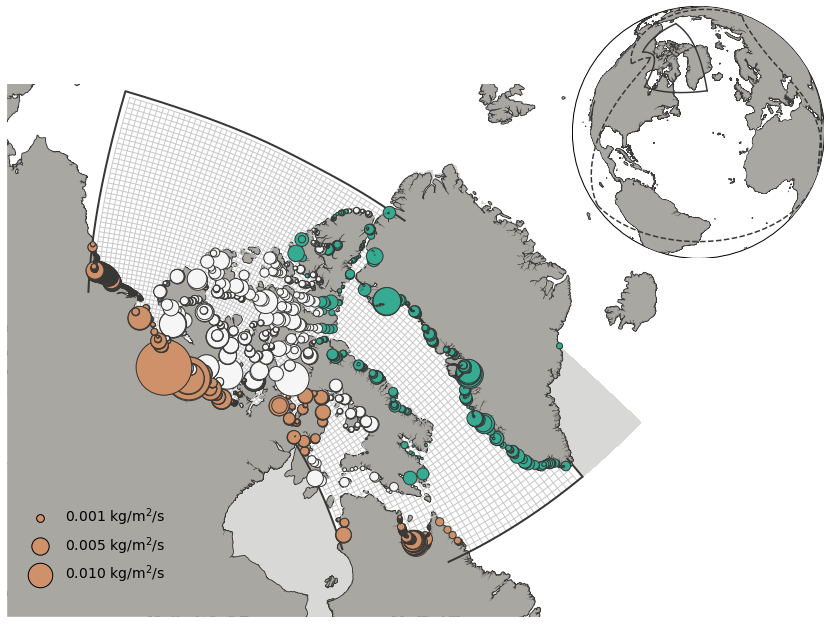

In [79]:
fig, ax1, proj1, ax2, proj2 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/pb-surface-globe.pickle','rb'))

#---------------- Main map -------------------------------------
x, y       = proj1(mesh_lon, mesh_lat) 
x_rf, y_rf = proj1(lon_rf, lat_rf)
x_grid, y_grid = proj1(grid_lon, grid_lat)

# Domain grid:
intval = 10
proj1.plot(x_grid[jmin:jmax:intval,imin:imax:intval], y_grid[jmin:jmax:intval,imin:imax:intval], '-', c=grid_color, lw=1, zorder=5);
proj1.plot(x_grid[jmin:jmax:intval,imin:imax:intval].T, y_grid[jmin:jmax:intval,imin:imax:intval].T, '-', c=grid_color, lw=1, zorder=5);

# Domain boundaries: 
proj1.plot(x[jmin:1136,680]   , y[jmin:1136,680]    , '-', c=outline_color, lw=2, zorder=5); # southeastern Greenland
proj1.plot(x[jmin,442:680]    , y[jmin,442:680]     , '-', c=outline_color, lw=2, zorder=5); # southern Baffin Bay
proj1.plot(x[jmax,392:imax-1] , y[jmax,392:imax-1]  , '-', c=outline_color, lw=2, zorder=5); # western Canada Basin
proj1.plot(x[1600:jmax,imax-1], y[1600:jmax,imax-1] , '-', c=outline_color, lw=2, zorder=5); # northern Canada Basin
proj1.plot(x[1190:1474,292]   , y[1190:1474,292]    , '-', c=outline_color, lw=2, zorder=5); # Hudson Bay bdy

proj1.contourf(x, y, bathy_masked[0,:,:], colors=[land_color]) # land mask

colormap = colors.ListedColormap([c_glacier, c_continent, c_other])
proj1.scatter(x_rf[jmin:jmax,imin:imax], y_rf[jmin:jmax,imin:imax], c=river_class[jmin:jmax,imin:imax],\
              s=rf[jmin:jmax,imin:imax]*6e4, alpha=1, cmap=colormap, zorder=6, edgecolor=outline_color)

for a in ['0.001', '0.005', '0.010']:
    proj1.scatter([], [], c=c_continent, alpha=1, s=float(a)*6e4, label=a + ' kg/m$^2$/s', \
                  edgecolors='k', zorder=4)

ax1.legend(scatterpoints=1, frameon=False, labelspacing=0.5, fontsize=14, loc=(0.02, 0.05))

#----------------Globe ------------------------------------------
x_gl, y_gl = proj2(mesh_lon, mesh_lat) 

# Domain boundaries: 
proj2.plot(x_gl[jmin:jmax,imin], y_gl[jmin:jmax,imin], '-', c=outline_color, lw=1.5, zorder=6); 
proj2.plot(x_gl[jmin,imin:imax], y_gl[jmin,imin:imax], '-', c=outline_color, lw=1.5, zorder=6); 
proj2.plot(x_gl[jmax,imin:imax], y_gl[jmax,imin:imax], '-', c=outline_color, lw=1.5, zorder=6); 
proj2.plot(x_gl[jmin:jmax,imax], y_gl[jmin:jmax,imax],  '-', c=outline_color, lw=1.5, zorder=6); 

# Full ANHA12 domain:
proj2.plot(x_gl[:,0], y_gl[:,0], '--', c=outline_color, lw=1.5, zorder=6); 
proj2.plot(x_gl[0,:], y_gl[0,:], '--', c=outline_color, lw=1.5, zorder=6); 
proj2.plot(x_gl[:,-1], y_gl[:,-1], '--', c=outline_color, lw=1.5, zorder=6); 
proj2.plot(x_gl[-1,:], y_gl[-1,:], '--', c=outline_color, lw=1.5, zorder=6); 
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb/A1-river-classification.png', bbox_inches='tight', dpi=300)